# **Récupération, pré-traitement et analyse de posts Reddit en rapport avec l'entreprise Apple afin de conduire une analyse de sentiments**

L'objectif de cette partie est de **récupérer des posts Reddit** relatifs à Apple afin de les **analyser** et de pouvoir les incorporer à notre **algorithme de trading final** sous forme d'une aide à la décision.

On va d'abord **importer** naïvement les derniers posts relatifs à Apple à l'aide de l'**API de Reddit**. On va ensuite trier ces données, les nettoyer et faire un ensemble de **statistiques descriptives** sur les posts nettoyés. Nous allons d'abord observer un nuage de mots sur les titres des derniers posts. Puis, nous créerons un dataframe regroupant les derniers posts, leur auteur, leur date de publication, leur titre ainsi que leur URL.

Par suite, nous observons le lien qui peut exister entre le nombre de posts publiés et le cours d'Apple en bourse.

Puis nous déterminons l'influence de certains auteurs dans le nombre de posts écrits.

Enfin, nous réaliserons des statistiques descriptives sur le dataframe créé initialment.


Tout d'abord, on installe **praw** et **wordcloud** qui seront deux bibliothèques essentielles pour la suite de ce notebook.

In [20]:
pip install praw wordcloud

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


On importe aussi toutes les **bibliothèques** qui nous serons utiles :

In [31]:
import praw
import pandas as pd
import numpy as np
from wordcloud import WordCloud,  STOPWORDS
import matplotlib.pyplot as plt
import re
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

On importe également les fonctions codées dans les fichiers précédents et qui nous serons à nouveau utiles ici :

In [32]:
def cleaning_text(text):
    #Passage du texte en miniscules
    text=text.lower()
    #Suppression des chiffres
    text=re.sub(r'\d+', '', text)
    #Suppresion de /r/
    text =re.sub(r'/r/', '', text)
    #Suppression de la ponctuation et des symboles spéciaux
    text=re.sub(r'[^\w\s]', '', text)
    return text


def count_common_words(text):
    words=text.split()
    dict={}
    for el in words :
        if el not in dict:
            dict[el]=1
        else:
            dict[el]+=1
    return dict

def most_common_words(dictionary):
    sorted_dict=dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict



def combine_dictionaries(df,df_column_name):
    combined_dict={}
    column_index=df.columns.get_loc(str(df_column_name))
    for i in range(len(df)):
        temp_dictionary=df.iloc[i,int(column_index)]

        for key, value in temp_dictionary.items():
            if key not in combined_dict:
                combined_dict[key]=value
            else:
                combined_dict[key]+=value
    return combined_dict

stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_stopwords(text):
    words = word_tokenize(text)
    cleaned_text=[word for word in words if word not in stops]
    return ' '.join(cleaned_text)

# **I/ Récupération des articles sous forme d'un dataframe**

Nous allons d'abord observer les mots les plus utilisés dans les titres des 500 derniers posts relatifs à Apple. Puis, nous allons créer et nettoyer un dataframe regroupant les informations principales concernants les posts concernant Apple. Pour ce faire, nous utilisons l'API de Reddit. Nous avons,préalablement, créé un profit "programmeur" sur Reddit. Ce profit permet d'obtenir l'identification client et le mot de passe, qui permettent d'importer les données de Reddit.

## 1/ Nuage de mots des 500 derniers posts sur Apple

On fait les configurations nécessaires à l'utilisation de PRAW pour la récupérations des posts:

In [23]:
reddit = praw.Reddit(client_id='xIq0ALkJ0RWzM5ZLwwiQKA',
                     client_secret='DeHliktGK8nfhDXsJFiebqgeZKhHXQ',
                     user_agent='Matlpg')

On récupère les 500 premiers posts du subreddit 'apple' :

In [24]:
subreddit = reddit.subreddit('apple')
top_posts = subreddit.new(limit=500) #On récupère ainsi les 500 derniers posts Reddit sur Apple

In [25]:
#Création d'un dataframe 
posts_data = []
for post in top_posts:
    text = post.selftext if post.selftext else "Text Not Available"
    date = pd.to_datetime(post.created_utc, unit='s')
    post_data = {
        "Titre": post.title,
        "Auteur": str(post.author),
        "Texte": text,
        "Date": date,
        "url": post.url
    }
    posts_data.append(post_data)

df = pd.DataFrame(posts_data)

On nettoie le texte récupéré :

In [38]:
df['Cleaned_text']=df['Texte'].apply(cleaning_text)
df['Cleaned_text']=df['Cleaned_text'].apply(clean_stopwords)

df.head()

,Titre,Auteur,Texte,Date,url,Cleaned_text
0,"Daily Advice Thread - December 29, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-29 11:00:34,https://www.reddit.com/r/apple/comments/18tkm9...,welcome daily advice thread apple thread used ...
1,Swipe on Dynamic Island (is this well known?) ...,safereddddditer175,\nIs this a well known feature? In MKBHD’s lat...,2023-12-29 10:08:57,https://youtu.be/YmwskGLycHo?si=oKM--J62UM7SE_hH,well known feature mkbhds latest iphone pro re...
2,Vision Pro 2 Rumored to Gain Brighter and More...,filmantopia,Text Not Available,2023-12-28 14:55:18,https://www.macrumors.com/2023/12/28/vision-pr...,text available
3,Inside Apple's Massive Push to Transform the M...,cheesepuff07,Text Not Available,2023-12-28 14:53:36,https://www.inverse.com/tech/mac-gaming-apple-...,text available
4,"Daily Advice Thread - December 28, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-28 11:00:30,https://www.reddit.com/r/apple/comments/18srcx...,welcome daily advice thread apple thread used ...


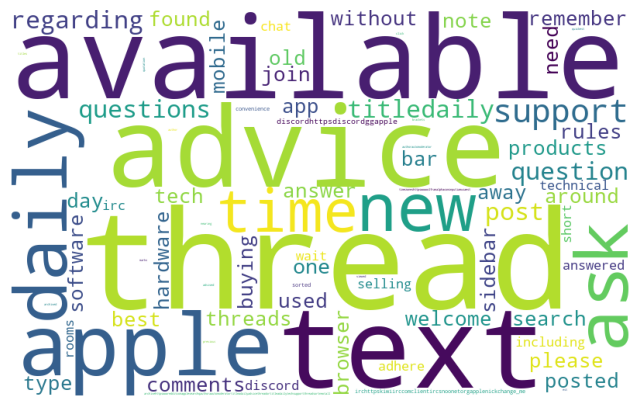

In [39]:
text=' '.join(df['Cleaned_text'])
words=text.split()
word_counts=Counter(words)
wordcloud = WordCloud(width = 800, height = 500, background_color ='white').generate_from_frequencies(word_counts)

plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

"**Advice thread**" revient très souvent. En effet, on remarque en analysant le dataframe, qu'un user publie **le même post** chaque jour avec à chaque fois ce titre. Nous pouvons l'enlever. 
Par ailleurs, on constate que de nombreux articles ne contiennent pas de texte. Ces derniers contiennent généralement un **lien** vers un article de presse extérieur à Reddit. Afin de récupérer du contenu plus intéressant, nous allons récupérer les **commentaires principaux** sous chacun des posts récupérés. Ce sont eux qui seront analysés par notre modèle de NLP.

## Récupération des commentaires principaux :

In [46]:
# Récupération des 5 commentaires principaux et ajout de ces derniers à notre dataframe

# Analyse descriptive du dataframe

Après avoir obtenu un dataframe nettoyé regroupant les 500 derniers posts Reddit relatifs à Apple, nous allors désormais utiliser ce dataframe pour tenter d'observer un lien entre le cours boursier d'Apple et le nombre de posts publiés. Puis nous observerons l'impact qu'ont certains utilisateurs sur le nombre de posts publiés. Enfin, nous réaliserons des statistiques descriptives sur les posts Reddit.

## A/ Lien entre le cours d'Apple et le nombre de posts écrits

Dans cette partie, nous allons observer s'il existe, a priori, un lien entre le nombre de posts publiés sur Reddit et relatifs à Apple et le cours d'Apple en bourse.

Tout d'abord, nous allons tracer un graphe regroupant, en abscisse, le temps et, en ordonnée, le nombre de posts cumulé publiés sur Reddit.

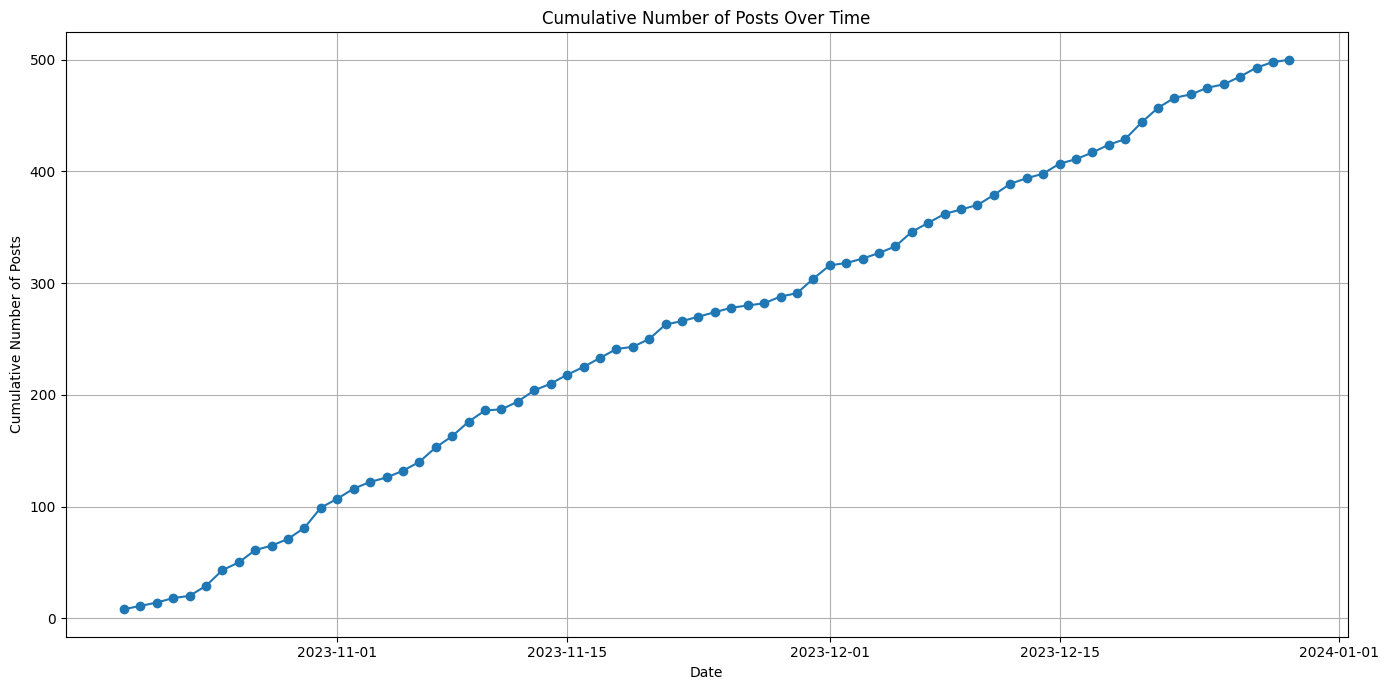

In [45]:
df['count'] = 1  #Cette colonne sert à compter les occurences
df_grouped = df.groupby(df['Date'].dt.date)['count'].sum().cumsum()

#On crée le graphique
plt.figure(figsize=(14, 7))
plt.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-')
plt.title('Cumulative Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Posts')
plt.grid(True)
plt.tight_layout()
plt.show()